<a href="https://colab.research.google.com/github/sochachai/Spam_Detection/blob/main/Spam_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Introduction
This notebook aims to train an LSTM to predict if an email is spam. After training, the model is saved as "spam_detection.json" (structure) and "spam_detection.weights.h5" (weights). These two files should be loaded for the purpose of further training or app development.

#### Install dependencies

In [ ]:
!pip install nltk
!pip install seaborn
!pip install wordcloud

#### Import libraries

In [2]:
# Importing necessary libraries for EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

# Importing libraries necessary for Model Building and Training
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#### Load Data and EDA

In [ ]:
data = pd.read_csv('emails_spam_normal.csv')
data.head()

In [4]:
data.shape

(5728, 2)

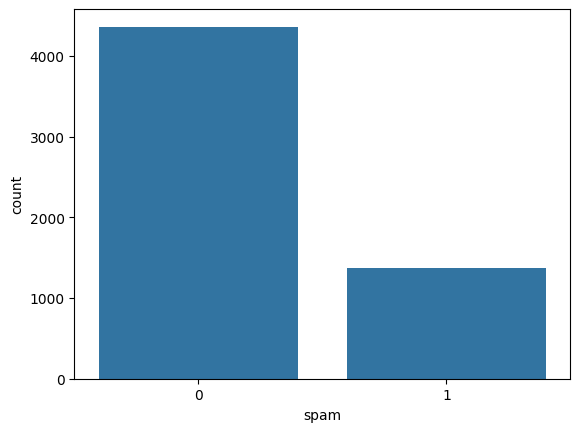

In [5]:
sns.countplot(x='spam', data=data)
plt.show()

#### Data Preprocessing

Text(0.5, 0, 'Message types')

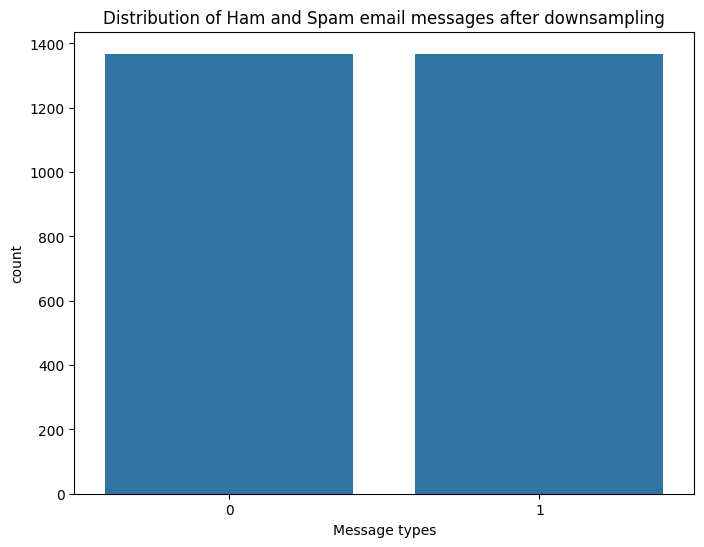

In [6]:
# Downsampling to balance the dataset
ham_msg = data[data.spam == 0]
spam_msg = data[data.spam == 1]
ham_msg = ham_msg.sample(n=len(spam_msg),random_state=42)

# Plotting the counts of down sampled dataset
balanced_data = pd.concat([ham_msg, spam_msg], ignore_index=True) # append was removed in pandas 2.0
plt.figure(figsize=(8, 6))
sns.countplot(data = balanced_data, x='spam')
plt.title('Distribution of Ham and Spam email messages after downsampling')
plt.xlabel('Message types')


In [7]:
balanced_data['text'] = balanced_data['text'].str.replace('Subject', '')
balanced_data.head()

text  spam
0  : interview schedule for jinbaek kim  i didn '...     0
1  : re : wednesday meeting  eric ,  i think we c...     0
2  : re : london research group  i ' d do it as s...     0
3  : re : congratulations  vince , thanks for you...     0
4  : osman sezgen  steve kromer is requesting tha...     0

In [8]:
punctuations_list = string.punctuation # !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list) # replace nothing, delete characters from punctuations_list
    return text.translate(temp)

balanced_data['text']= balanced_data['text'].apply(lambda x: remove_punctuations(x))
balanced_data.head()

text  spam
0   interview schedule for jinbaek kim  i didn  t...     0
1   re  wednesday meeting  eric   i think we can ...     0
2   re  london research group  i  d do it as soon...     0
3   re  congratulations  vince  thanks for your n...     0
4   osman sezgen  steve kromer is requesting that...     0

In [9]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')

    imp_words = []

    # Storing the important words
    for word in str(text).split():
        word = word.lower()

        if word not in stop_words:
            imp_words.append(word)

    output = " ".join(imp_words)

    return output


balanced_data['text'] = balanced_data['text'].apply(lambda text: remove_stopwords(text))
balanced_data.head()

text  spam
0  interview schedule jinbaek kim see went happy ...     0
1  wednesday meeting eric think skip meeting disc...     0
2  london research group soon possible call exact...     0
3  congratulations vince thanks note congratulati...     0
4  osman sezgen steve kromer requesting osman spe...     0

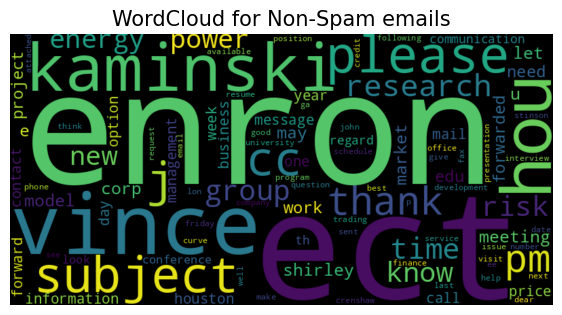

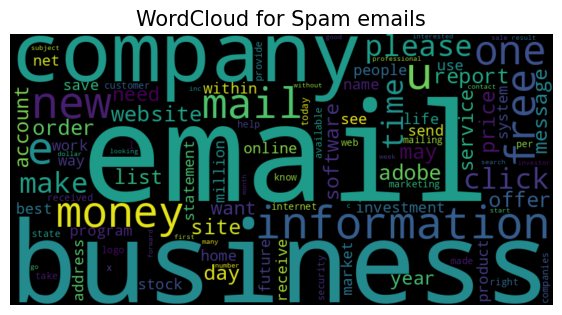

In [10]:
def plot_word_cloud(data, typ):
    email_corpus = " ".join(data['text'])

    plt.figure(figsize=(7, 7))

    wc = WordCloud(background_color='black',
                   max_words=100,
                   width=800,
                   height=400,
                   collocations=False).generate(email_corpus)

    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'WordCloud for {typ} emails', fontsize=15)
    plt.axis('off')
    plt.show()

plot_word_cloud(balanced_data[balanced_data['spam'] == 0], typ='Non-Spam')
plot_word_cloud(balanced_data[balanced_data['spam'] == 1], typ='Spam')

In [11]:
#train test split
train_X, test_X, train_Y, test_Y = train_test_split(balanced_data['text'],
                                                    balanced_data['spam'],
                                                    test_size = 0.2,
                                                    random_state = 42)

In [23]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X) #https://datascience.stackexchange.com/questions/116808/what-is-the-math-behind-the-keras-tokenizer-function#:~:text=Class%20Tokenizer%20is%20used%20to,dictionary%2C%20you%20usually%20invoke%20fit_on_texts%20.

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)

# Pad sequences to have the same length
max_len = 100  # maximum sequence length
train_sequences = pad_sequences(train_sequences,
                                maxlen=max_len,
                                padding='post',
                                truncating='post')
test_sequences = pad_sequences(test_sequences,
                               maxlen=max_len,
                               padding='post',
                               truncating='post')

#### Modeling

In [24]:
# Build the model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1,
                                    output_dim=32,
                                    input_length=max_len))
model.build((None,max_len)) # build the Embedding to inilizices the weight
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 100, 32)             │         805,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 16)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 808,737 (3.09 MB)

 Trainable params: 808,737 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics = ['accuracy'],
              optimizer = 'adam')

In [26]:
es = EarlyStopping(patience=3,
                   monitor = 'val_accuracy',
                   restore_best_weights = True)

lr = ReduceLROnPlateau(patience = 2,
                       monitor = 'val_loss',
                       factor = 0.5,
                       verbose = 0)

In [27]:
# Train the model
history = model.fit(train_sequences, train_Y,
                    validation_data=(test_sequences, test_Y),
                    epochs=20,
                    batch_size=32,
                    callbacks = [lr, es])

Epoch 1/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.6261 - loss: 0.6799 - val_accuracy: 0.8084 - val_loss: 0.4971 - learning_rate: 0.0010
Epoch 2/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.9511 - loss: 0.2668 - val_accuracy: 0.9398 - val_loss: 0.2319 - learning_rate: 0.0010
Epoch 3/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9558 - loss: 0.1840 - val_accuracy: 0.9544 - val_loss: 0.1872 - learning_rate: 0.0010
Epoch 4/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9678 - loss: 0.1381 - val_accuracy: 0.9599 - val_loss: 0.1733 - learning_rate: 0.0010
Epoch 5/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.9814 - loss: 0.0900 - val_accuracy: 0.9562 - val_loss: 0.1903 - learning_rate: 0.0010
Epoch 6/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.9878 - loss: 0.0675 - val_accuracy: 0.9526 - val_loss: 0.2069 - learning_rate: 0.0010
Epoch 7/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9909 - loss: 0.0538 - val_acc

In [28]:
model.predict(np.array([test_sequences[0]]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


array([[0.01644517]], dtype=float32)

In [31]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 100, 32)             │         805,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 16)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,426,213 (9.26 MB)

 Trainable params: 808,737 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,617,476 (6.17 MB)

#### Save model

In [38]:
# keras library import  for Saving and loading model and weights

from keras.models import model_from_json
from keras.models import load_model

# serialize model to JSON
#  the keras model which is trained is defined as 'model' in this example
model_json = model.to_json()


with open("spam_detection.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("spam_detection.weights.h5")

#### Load model

In [45]:
# load json and create model
json_file = open('spam_detection.json', 'r')

loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("spam_detection.weights.h5")
#loaded_model.save('spam_detection.hdf5')
#loaded_model=load_model('spam_detection.hdf5')

#### Some Predictions

In [46]:
loaded_model.predict(np.array([[1128, 3, 36]]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


array([[0.2346086]], dtype=float32)

In [48]:
model.predict(np.array([[1128, 3, 36]]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


array([[0.2346086]], dtype=float32)

In [47]:
loaded_model.predict(np.array([test_sequences[0]]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


array([[0.01644517]], dtype=float32)

#### Model Evaluation

In [22]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_sequences, test_Y)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9359 - loss: 0.2035
Test Loss : 0.22367434203624725
Test Accuracy : 0.9343065619468689


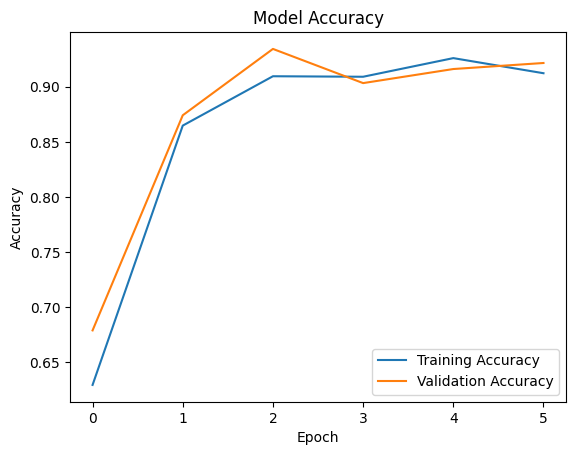

In [23]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()